In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [2]:
# total number of actions
df.shape[0]

8188

In [3]:
# number of unique users
df_uniq = df.drop_duplicates(subset='id')
df_uniq.shape[0]

6328

In [4]:
# size of control group and experiment group
control = df_uniq[df_uniq.group == 'control']
experiment = df_uniq[df_uniq.group == 'experiment']
control.shape[0], experiment.shape[0]

(3332, 2996)

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [5]:
# duration of this experiment
df_uniq.timestamp.min(), df_uniq.timestamp.max()

('2016-09-24 17:42:27.839496', '2017-01-18 10:24:08.629327')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [6]:
df.action.unique()

array(['view', 'click'], dtype=object)

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

AS páginas de controle e de teste podem ter numeros diferentes do total de visitantes. Mais cliques totais podem ocorrer em uma versão, mesmo se houver uma porcentagem muito maior de cliques em outra versão. Obter a proporção de usuários que clicam é mais eficaz do que obter número de usuários que clicam quando comparamos grupos de diferentes tamanhos.

### 5. Define the click through rate (CTR) for this experiment.

Numero de visitantes unicos que clicam pelo menos uma vez dividido pelo numero de visitantes unicos que visualizam a pagina

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: CTR_{new} - CTR_{old} <= 0$$
$$H_1: CTR_{new} - CTR_{old} > 0$$

In [7]:
#click-through rate for control users
control_df = df.query('group == "control"')
control_ctr = control_df.query('action == "click"').id.nunique() /  control_df.query('action == "view"').id.nunique()
control_ctr

0.2797118847539016

In [8]:
#click-through rate for experiment users
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
experiment_ctr

0.3097463284379172

In [9]:
# Experiment group's ctr was higher than the control by about 3 %
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030034443684015644

In [10]:
# We have to see if this difference is significant and not just due to chance
# Let's bootstrap the sample to simulate the sampling distribution for the difference in proportions
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True) # Use all the sample but replacing
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query(
        'action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query(
        'action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

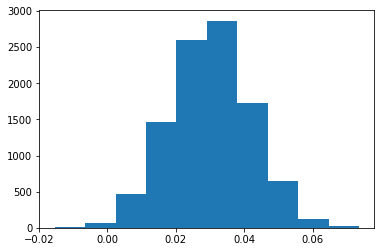

In [11]:
# Take a diffs at our sampling distribution
plt.hist(diffs);

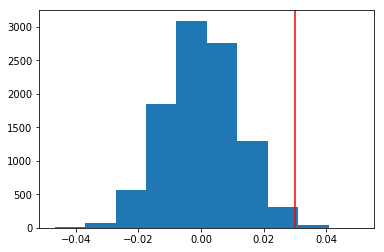

In [12]:
# p-value: The observed difference in proportions by simulating the distribution under the null hypothesis and then
# finding the probability that our statistic came from this distribution
# To simulate from the null, we'll create a normal distribution centered at zero, with the same standard deviation
# as our sampling distribution we simulated here.
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)
# See the null distribution
plt.hist(null_vals);
# this is where our observed statistic falls
plt.axvline(x=obs_diff, color='red')

In [13]:
# We can't find p-value like this, as this are all the null values that are more extreme than our statistic
# in favor of our alternative
(null_vals > obs_diff).mean()

0.0057

In [14]:
# With a p-value of approximately a half of percent (less than 0.01 seems unlikely 
# that our statistic is from tis null), the difference in click-through rates for the control and
# experiment groups does appear to be significant. We can reject the null hypothesis

# Enrollment rate

In [15]:
np.random.seed(42)
df = pd.read_csv('course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [16]:
# Get dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').count()[0] / control_df.query('action == "view"').count()[0]

# Display click through rate
control_ctr

0.23452157598499063

In [17]:
# Get dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').count()[0] / \
experiment_df.query('action == "view"').count()[0]

# Display click through rate
experiment_ctr

0.2642986152919928

In [18]:
# Compute the observed difference in click through rates
obs_diff = control_ctr - experiment_ctr

# Display observed difference
obs_diff

-0.02977703930700215

In [19]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').count()[0] / control_df.query('action == "view"').count()[0]
    experiment_ctr = experiment_df.query('action == "enroll"').count()[0] / experiment_df.query('action == "view"').count()[0]
    diffs.append(experiment_ctr - control_ctr)

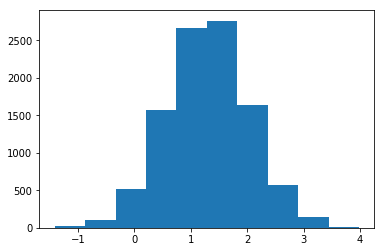

In [58]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

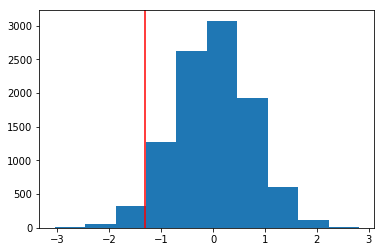

In [59]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

# Plot the null distribution
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

In [56]:
# Compute p-value
(null_vals < obs_diff).mean()
# Você possui evidências, com uma taxa de erros de Tipo I de 0,05, de que a taxa de inscrição 
# deste curso aumenta quando utilizamos uma descrição experimental na página de visão geral (p-value < alfa)

0.0321

# Average reading duration
* This metric, we'll be analysing the difference in means

In [27]:
df = pd.read_csv('course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [31]:
# Since we're comparing reading durations, we only care about view actions
views = df.query('action == "view"')
# and let's only count each unique user once, by finding their average reading duration if they 
# visited the site more than once
reading_times = views.groupby(['id', 'group'])['duration'].mean()
reading_times = reading_times.reset_index()
reading_times.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [32]:
# Find the average reading durations for each group
control_mean = df.query('group=="control"')['duration'].mean()
experiment_mean = df.query('group=="experiment"')['duration'].mean()
control_mean, experiment_mean

(115.40710650582038, 130.93220512539477)

In [33]:
# On average, it looks like users in the experiment group spent 15 more seconds
# on the course overview page than those in the control group
obs_diff = experiment_mean - control_mean
obs_diff

15.525098619574393

In [34]:
# Calculate sampling distribution in the difference mean reading durations
# to see if the difference is significant
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_mean = b_samp.query('group == "control"')['duration'].mean()
    experiment_mean = b_samp.query('group == "experiment"')['duration'].mean()
    diffs.append(experiment_mean - control_mean)

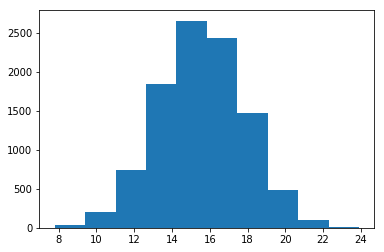

In [39]:
diffs = np.array(diffs)
plt.hist(diffs);

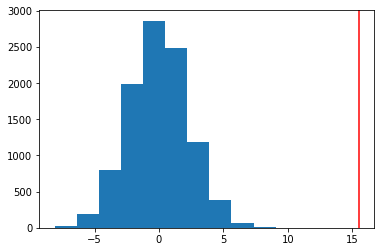

In [43]:
# To find p-value, let's simulate the distribution under the null and find the probability
# that our observed statistic came from this distribution (centered at zero and same spread
# of the sample distribution)
null_vals = np.random.normal(0, diffs.std(), diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red') # where statistic falls and it doesn't look like it came 
# from this null distribution. Looks like the difference we observed is significant

# Average classroom time

In [44]:
df = pd.read_csv('classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [45]:
# The total_days represents the total amount of time
# each student has spent in classroom.
# get the average classroom time for control group
control_mean = df.query('group=="control"')['total_days'].mean()

# get the average classroom time for experiment group
experiment_mean = df.query('group=="experiment"')['total_days'].mean()

# display average classroom time for each group
control_mean, experiment_mean

(73.36899038461539, 74.6715935334873)

In [46]:
# compute observed difference in classroom time
obs_diff = control_mean - experiment_mean

# display observed difference
obs_diff

-1.3026031488719099

In [47]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_mean = b_samp.query('group=="control"')['total_days'].mean()
    experiment_mean = b_samp.query('group=="experiment"')['total_days'].mean()
    diffs.append(experiment_mean - control_mean)

In [48]:
# convert to numpy array
diffs = np.array(diffs)

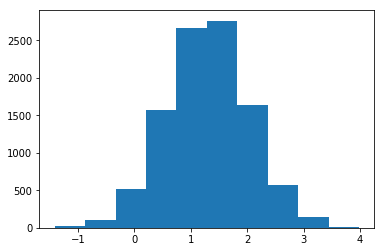

In [50]:
# plot sampling distribution
plt.hist(diffs);

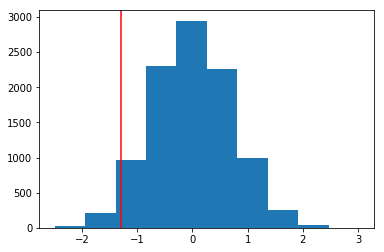

In [51]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)
# plot line for observed statistic
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

In [55]:
# Compute p-value
(null_vals < obs_diff).mean()
# Você possui evidências, com uma taxa de erros de Tipo I de 0,05, de que usuários passam mais tempo em sala de aula

0.0321

# Completion rate

In [3]:
df = pd.read_csv('classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [4]:
# Create dataframe with all control records
control_df = df.query('group == "control"')

# Compute completion rate
control_ctr = control_df['completed'].mean()

# Display control complete rate
control_ctr

0.3719951923076923

In [5]:
# Create dataframe with all experiment records
experiment_df = df.query('group == "experiment"')

# Compute completion rate
experiment_ctr = experiment_df['completed'].mean()

# Display experiment complete rate
experiment_ctr

0.3935334872979215

In [8]:
# Compute observed difference in completion rates
obs_diff = experiment_ctr - control_ctr

# Display observed difference in completion rates
obs_diff

0

In [7]:
# Create sampling distribution for difference in completion rates
# with boostrapping
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True)
    control_df = b_samp.query('group=="control"')
    control_ctr = control_df.query('completed==True').count()[0] / \
    control_df.query('completed==False').count()[0]
    experiment_df = b_samp.query('group=="experiment"')
    experiment_ctr = experiment_df.query('completed==True').count()[0] / \
    experiment_df.query('completed==False').count()[0]
    diffs.append(experiment_ctr-control_ctr)

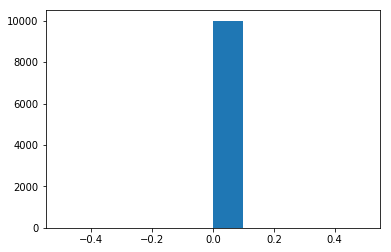

In [9]:
# convert to numpy array
diffs = np.array(diffs)
# plot distribution
plt.hist(diffs);

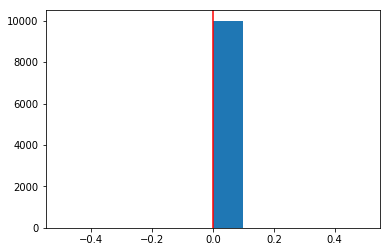

In [10]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.shape[0])
# plot line for observed statistic
plt.hist(null_vals);
plt.axvline(obs_diff, color='red')

In [12]:
# compute p value
(null_vals < obs_diff).mean()
#valor-p seja menor do que o parâmetro alfa, isso sugere que há uma diferença estatisticamente significativa

0.0